<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 527 Homework 1

## **Group Members: Beck Addison, Shivam Kaul, Gin Wang**

### Problem 0 (3 points)

## Part 1: Correlation and Convolution Basics

In general, correlation has the following formula:

$$
corr(r, c) = \sum^{h}_{u = -h} \sum^{h}_{v = -h} I(r + u, c + v)T(u, v)
$$ 

while convolution has the formula:

$$
conv(r, c) = \sum^{h}_{u = -h} \sum^{h}_{v = -h} I(r - u, c - v)H(u, v)
$$

where, for some matrix with dimensions $R \times C$ a "window" in the matrix is centered at $(r,c) \in (R,C)$. Each pixel in the window spanning from $(r - h, c - h)$ to $(r + h, c + h)$ (where h is the "radius" of the window) is transformed by a kernel or template.

$% formulas for the stuff in 1.1
\newcommand{\conv}[3]{\text{conv}(#1, #2, \text{'#3'})}
\newcommand{\corr}[3]{\text{corr}(#1, #2, \text{'#3'})}
\newcommand{\I}{
    \begin{bmatrix}
    1 &  0 &  3 & -2 &  0 \\
    0 &  2 & -1 &  4 &  0 \\
    0 &  1 &  0 &  1 &  0 \\
    2 & -2 &  0 &  1 & -1 \\
    \end{bmatrix}
}
\newcommand{\J}{
    \begin{bmatrix}
    4 &  0 \\
    1 & -5 \\
    \end{bmatrix}
}
\newcommand{\H}{
    \begin{bmatrix}
    2 & 0 & 1 \\
    1 & -1 & 3 \\
    \begin{bmatrix}
}
\newcommand{\K}{
    \begin{bmatrix}
    1 & 0 & -1
    \end{bmatrix}
}$

### Problem 1.1 (Exam Style)

$
\corr{I}{H}{valid} = 
    \begin{bmatrix}
         0 & 13 &  1 \\
        -2 & 12 & -3 \\
         4 &  4 & -4 \\
    \end{bmatrix}
$

$
\conv{I}{H}{valid} =
    \begin{bmatrix}
         4 &  5 & 10 \\
        -3 & 14 & -7 \\
         1 &  4 &  1 \\
    \end{bmatrix}
$

$
\conv{I}{K}{valid} = 
    \begin{bmatrix}
         2 & -2 & -3 \\
        -1 &  2 &  1 \\
         0 &  0 &  0 \\
        -2 &  3 & -1 \\
    \end{bmatrix}
$

$
\conv{J}{H}{full} =
    \begin{bmatrix}
         8 &   0 &  4 &   0 \\
         6 & -14 & 13 &  -5 \\
         1 &  -6 &  8 & -15 \\
    \end{bmatrix}
$

$
\corr{J}{H}{same} = 
    \begin{bmatrix}
        4 &   0 \\
        2 & -10 \\
    \end{bmatrix}
$

### Problem 1.2 (Exam Style)

For some matrix $H$ to be separable, there must be some column vector  $\vec{h_c}$ of dimension $m \times 1$ and some row vector $\vec{h_r}$ of dimension $1 \times n$ for which $H$ is the product. In other words,

$$ \vec{h_r} \times \vec{h_c} = H $$

For any separable matrix, *the rank of that matrix is therefore 1*, because each row is a scalar multiple of the other rows. In particular, if the given matrix $H$ is separable, the vectors $\vec{h_r}$ and $\vec{h_c}$ are:

$ \vec{h_r} = \begin{bmatrix} 1 & -1 & 2 \end{bmatrix} $

$ \vec{h_c} = \begin{bmatrix} 1 \\ -3 \\ 0 \end{bmatrix} $

This means that the missing values for this matrix are 

$$
\begin{bmatrix}
1 & -1 & 2 \\
a &  3 & b \\
c &  d & 0 \\
\end{bmatrix}

\rightarrow

\begin{bmatrix}
 1 & -1 & 2 \\
-3 &  3 & 6 \\
 0 &  0 & 0 \\
\end{bmatrix}

$$

$$(a, b, c, d) = (-3, -6, 0, 0)$$ 

### Problem 1.3 (Exam Style)

A kernel $H(x,y)$ is separable if the kernel can be equated to $H(x,y) = h(x)l(y)$.

By extension, a kernel is not separable if for any $(x_0,y_0) \in (x,y)$ the following equality is not preserved:

$$ H(x_0, y_0)H(x,y) = H(x,y_0)H(x_0, y) $$

$D(x,y) = xe^{x^2 + y}$:

$$ d_1(x) = xe^{x^2} $$
$$ d_2(y) = e^y $$

$ L(x,y) = (x^2 + y^2)e^{x^2 + y^2} $:

This function is not multiplicatively separable - there is no way to generate the equality $L(x,y) = l_1(x)l_2(y)$.

$U(x,y) = 1$:

$$u_1(x) = 1$$
$$u_2(y) = 1$$

$L(x,y) = (x^2+y^2)e^{x^2+y^2}$:

$$L(x,y) = \frac{e^{x^2+y^2}}{dx dy}$$
$$L(x,y) = \frac{e^{x^2}e^{y^2}}{dx dy}$$
$$g(x) =\frac{e^{x^2}}{dx}, g(y) =\frac{e^{y^2}}{dy}$$

# Part 2: Implementing Convolution

In [52]:
import numpy as np
import scipy.signal as ss
from time import perf_counter as stopwatch


def add_timer(f):
    def wrapper(*args, **kwargs):
        tic = stopwatch()
        ret = f(*args, **kwargs)
        t = stopwatch() - tic
        return ret, t

    return wrapper


@add_timer
def convolution(f, h, mode='valid'):
    assert f.ndim == h.ndim, 'inputs must have the same number of dimensions'
    g = ss.convolve(f, h, mode=mode, method='direct')
    return g.astype(f.dtype)

In [53]:
from urllib.request import urlretrieve as retrieve
from os import path as osp
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline


def show_image(img, name=None):
    plt.imshow(img, cmap='gray')
    if name is not None:
        plt.title(name)
    plt.axis('off')
    

local_file_name = 'breakfast.png'
if not osp.exists(local_file_name):
    image_url = 'https://www2.cs.duke.edu/courses/spring21/' +\
                'compsci527/homework/1/breakfast.png'
    retrieve(image_url, local_file_name)
image = np.array(Image.open(local_file_name))

The convolution took 0.859 seconds to compute


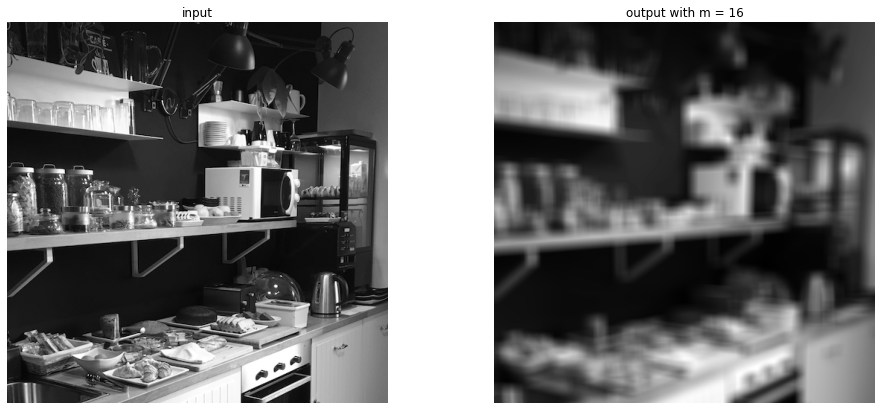

In [ ]:
m = n = 16
box = np.ones((m, n), dtype=float) / (m * n)
smooth, process_time = convolution(image, box)
print('The convolution took {:.3f} seconds to compute'.format(process_time))

plt.figure(figsize=(16, 7))
for plot, (img, name) in enumerate(((image, 'input'),
                                    (smooth, 'output with m = {}'.format(m)))): 
    plt.subplot(1, 2, plot + 1)
    show_image(img, name)
plt.show()

In [54]:
def largest_difference(i, j):
    return np.amax(np.abs(i.astype(int) - j.astype(int)))

### Problem 2.1

In [145]:
@add_timer
def python_convolution(f, h):
    '''
    Instructions for 'valid' convolution
    '''

    assert f.ndim == 2, 'input array must be two-dimensional'
    assert h.ndim == 2, 'kernel must be two-dimensional' 

    #get input matrices' data
    f_rows, f_cols = len(f), len(f[0])
    h_rows, h_cols = len(h), len(h[0])

    #generate output matrix
    output_rows, output_cols = f_rows - h_rows + 1, f_cols - h_cols + 1
    output_matrix = np.zeros(shape = (output_rows, output_cols))

    for r in range(output_rows):
        for c in range(output_cols):        
            for h_row in range(h_rows):
                for h_col in range(h_cols):
                    output_matrix[r, c] = output_matrix[r, c] + h[h_rows - (h_row + 1), h_cols - (h_col + 1)] * f[r + h_row, c + h_col]
    return output_matrix.astype(dtype = type(f))

@add_timer
def scipy_convolve(image, kernel, mode = 'valid'):
    return ss.convolve(image, kernel, mode)


#### Runtime comparison of `python_convolution` and `scipy.signal.convolve`:

In [146]:
box_kern = np.ones((3,4))
box_kern = box_kern/np.sum(box_kern)

In [7]:
py_conv_image, py_conv_time1 = python_convolution(image, box_kern)
sc_conv_image, sc_conv_time1 = scipy_convolve(image, box_kern)

(array([[ 2., -2., -3.],
       [-1.,  2.,  1.],
       [ 0.,  0.,  0.],
       [-2.,  3., -1.]]), 0.00016425500000138982)


In [151]:
py_sc_diff = largest_difference(py_conv_image, sc_conv_image)

In [165]:
print("Python time: {:.3f} s, SciPy time: {:.3f} s, Ratio: {:.3f} (Python:SciPy), Maximum output difference: {:d}".format(py_conv_time1, sc_conv_time1, py_conv_time1/sc_conv_time1, py_sc_diff))

Python time: 4.566 s, SciPy time: 0.034 s, Ratio: 135.705 (Python:SciPy), Maximum output difference: 1


### Problem 2.2

In [56]:
@add_timer
def separable_convolution(f, h, mode = "valid"): 
    m_by_one, one_by_n = h
    
    convolution_intermediate = ss.convolve(
        f,
        m_by_one,
        mode)
    
    convolution_final = ss.convolve(
        convolution_intermediate,
        one_by_n,
        mode)
    return convolution_final.astype(dtype = type(f))


In [57]:
round_val = 3
m = [2**i for i in range(1,7)]

data = {
    'm': [],
    'pyconv_times': [],
    'spconv_times': [],
    'differences': []
}
for m_val in m:
    
    box_filter_m_by_one = np.ones((m_val, 1), dtype = float) / m_val
    box_filter_one_by_n = np.ones((1, m_val), dtype = float) / m_val
    box_filter = box_filter_m_by_one * box_filter_one_by_n
    
    pyconv_image, pyconv_time = python_convolution(image, box_filter)
    spconv_image, spconv_time = separable_convolution(image, (box_filter_m_by_one, box_filter_one_by_n))
    largest_diff = largest_difference(pyconv_image, spconv_image)
    
    data['m'].append(m_val)
    data['pyconv_times'].append(round(pyconv_time, round_val))
    data['spconv_times'].append(round(spconv_time, round_val))
    data['differences'].append(round(largest_diff, round_val))

KeyboardInterrupt: 

In [172]:
from tabulate import tabulate
from IPython.core.display import display, HTML

tb1_2_2 = tabulate(data, headers = ["box kernel size (m)", "python_convolution times (s)", "separable_convolution times (s)", "maximum output difference"], tablefmt = "html")

display(HTML(tb1_2_2))

box kernel size (m),python_convolution times (s),separable_convolution times (s),maximum output difference
2,1.513,0.035,0
4,5.294,0.022,1
8,20.442,0.021,1
16,77.667,0.021,1
32,317.505,0.033,1
64,1150.36,0.024,1


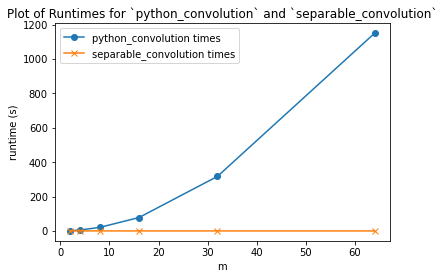

In [167]:
fig, ax = plt.subplots()

ax.plot(data['m'], data['pyconv_times'], label = "python_convolution times", marker = 'o')
ax.plot(data['m'], data['spconv_times'], label = "separable_convolution times", marker = 'x')
ax.set_xlabel('m')
ax.set_ylabel('runtime (s)')
ax.set_title('Plot of Runtimes for `python_convolution` and `separable_convolution`')
ax.legend()

The runtimes for both functions are for the most part expected. `python_convolution` is approximately $O(n^4)$ (in truth, it is $O(r*c*l*m)$, where $(r,c)$ are the dimensions of the image and $(l,m)$ are the dimensions of the kernel, but this can be generalized to one variable as the values approach infinity). The runtime for `separable_convolution` appears to be $O(1)$, primarily because of the strong optimization of `ss.convolve`, but as the size of the separable kernel approaches infinity, the runtime also scales with the kernel and image size - however, since the operations are one after the other (an intermediate and then final convoluted image), the runtime scales additively, rather than multiplicatively.

### Problem 2.3

In [64]:
import skimage.transform.integral as integral
def integral_image(f):
    return np.pad(integral.integral_image(f), ((1, 0), (1, 0)))

In [65]:
@add_timer                      # something's wrong down here
def box_convolution(f, size):
    F = integral_image(f)
    m, n = size
    r, c = F.shape
    average = m*n
    F_s = F[m:, n:] # just outside of the mxn box
    F_p = F[:r-m, :c-n] # always inside the mxn box
    F_q = F[:r-m, n:] # just after the nth column, always inside the mth row 
    F_r = F[m:, :c-n] # just under the mth row, always inside the nth column 
    convolution = (F_s - F_q - F_r + F_p)/average
    return convolution.astype(dtype = type(f))

In [105]:
report_table = {
    'time' : {
        'convolution' : None,
        'separable_convolution' : None,
        'box_convolution' : None,
    },
    'speedup_factors' : {
        'convolution/separable_convolution' : None,
        'convolution/box_convolution' : None,
        'separable_convolution/box_convolution' : None,
    },
    'largest_difference' : {
        'convolution-separable_convolution': None,
        'convolution-box_convolution': None,
    }
}

In [106]:
m, n = 32, 64
bf_m_by_one = np.ones(shape = (m, 1), dtype = float)/m
bf_one_by_n = np.ones(shape = (1, n), dtype = float)/n
bf = (bf_m_by_one*bf_one_by_n)

ValueError: operands could not be broadcast together with shapes (481,64) (32,64) 

In [107]:
image_pc, report_table['time']['convolution'] = python_convolution(image, bf)

In [113]:
image_sc, report_table['time']['separable_convolution'] = separable_convolution(image, (bf_m_by_one, bf_one_by_n))

In [114]:
image_bc, report_table['time']['box_convolution'] = box_convolution(image, (m, n))

In [134]:
report_table['speedup_factors']['convolution/separable_convolution'] = report_table['time']['convolution']/report_table['time']['separable_convolution']
report_table['speedup_factors']['convolution/box_convolution'] = report_table['time']['convolution']/report_table['time']['box_convolution']
report_table['speedup_factors']['separable_convolution/box_convolution'] = report_table['time']['separable_convolution']/report_table['time']['box_convolution']

In [135]:
report_table['largest_difference']['convolution-separable_convolution'] = largest_difference(image_pc, image_sc)
report_table['largest_difference']['convolution-box_convolution'] = largest_difference(image_pc, image_bc)

In [137]:
#make the dict table-readable by tabulate
for (k1,nest_dict) in report_table.items():
    for (k2, v) in nest_dict.items():
        if type(nest_dict[k2]) != list:
            nest_dict[k2] = [v]

The output of the tests we've run are below:

### Time taken by each of the three functions (s):

In [173]:
tb1_2_3 = tabulate(report_table['time'], headers = 'keys', tablefmt = "html")
display(HTML(tb1_2_3))

convolution,separable_convolution,box_convolution
575.882,0.0433817,0.0158439


### Speedup factors as ratios of runtimes

In [174]:
tb2_2_3 = tabulate(report_table['speedup_factors'], headers = 'keys', tablefmt = "html")
display(HTML(tb2_2_3))

convolution/separable_convolution,convolution/box_convolution,separable_convolution/box_convolution
13274.8,36347.2,2.73807


### Largest difference values

In [175]:
tb3_2_3 = tabulate(report_table['largest_difference'], headers = 'keys', tablefmt = "html")
display(HTML(tb3_2_3))

convolution-separable_convolution,convolution-box_convolution
1,0


### Problem 2.4

For every pixel in the input image, the kernel applies 7 scalar operations. The first three are done by generating the integral image in the first place. The second three are applied by getting the space $S$ from $S = F(s) - F(q) - F(r) + F(p)$. The last operation is the division of the space by the uniform scalar value $m*m$, where $(m,m)$ are the dimensions of the box kernel applied to the image. Notice, however, that the runtime of the operation is contingent only on the size of the input image, as that governs the number of pixels that those $O(1)$ operations have to be performed on.

Compared to `box_convolution`, both separable and normal convolution (`python_convolution`) have more operations per pixel, and, unlike `box_convolution`, these operations increase with the size of the kernel. For a basic convolution, we multiply a single pixel at most $2mn$ times. Separable convolution reduces the number of operations by producing an "intermediate" convoluted image - the number of operations performed on the input image by a separable matrix is first at most $2m$ operations, then $2n$ operations, for a total of $2m + 2n$ operations per pixel.